# Parse the Newsroom HTML

Now that we've collected all of the HTML we needed from each of the company's newsrooms, we can begin to parse the HTML to gather all of the links, filter out the links that don't lead to press releases.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import os

import warnings
warnings.filterwarnings('ignore')

## Get a list of all the HTML files

In [2]:
files = os.listdir('../data/html/')
html_files = [f for f in files if 'html' in f]
html_files

['exxon_mobil_html.csv',
 'walmart_html.csv',
 'amazon_html.csv',
 'cvs_health_html.csv',
 'apple_html.csv']

### Get all the links from each block of html in each of the files 

For each file in the html folder, parse the HTML in each row to gather all of the links from the webpage, which are then saved as new files in the links folder.

In [3]:
# iterate through all the files in the folder
for file in tqdm(html_files):

    # create a new file name for later
    new_file_name = file.replace('html.csv', 'links.csv')
    link_files = os.listdir('../data/links/')
    
    # create a dataframe from the csv file
    df = pd.read_csv(f'../data/html/{file}')

    # start a list that information can be appended to
    hrefs = []

    for row in range(len(df)):

        # get html from each row of the dataframe
        html = df.loc[row, 'html']

        # use BeautifulSoup to read in the html
        soup = BeautifulSoup(html, 'lxml')

        # get a list of all the tags on that page
        tags = set([tag.name for tag in soup.find_all()])

        # iterate through all of the possible tags to get
        # all of the links, regardless of how it is tagged
        for tag in tags:

            # iterate through all of the elements with that tag
            for element in soup.find_all(tag):
                # open a dictionary to append to the hrefs list
                href = {}
                # only append if the element has a link
                if 'href' in element.attrs:
                    href['company'] = df.loc[row, 'company']
                    href['newsroom_page'] = row
                    href['tag'] = tag
                    href['link'] = element.attrs['href']
                    hrefs.append(href)

    links = pd.DataFrame(hrefs).drop_duplicates(subset=['link']).dropna()
    links.to_csv(f'../data/links/{new_file_name}', index=False)

100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


## Editing `links` files

Knowing 

In [4]:
link_files = [f for f in os.listdir('../data/links/') if 'csv' in f]
link_files

['apple_links.csv',
 'walmart_links.csv',
 'cvs_health_links.csv',
 'amazon_links.csv',
 'exxon_mobil_links.csv']

In [5]:
prior_lengths = []

for file in link_files:
    info = {}
    df = pd.read_csv(f'../data/links/{file}')
    info['company'] = df['company'][0]
    info['prior_length'] = len(df)
    prior_lengths.append(info)
    
priors = pd.DataFrame(prior_lengths)

Due to the volume of unnecessary/irrelevant links obtained by just grabbing all of the HTML from the webpage, the below filters out anything that *isn't* a link to a press release using a loop and saving the filtered DataFrame back to the links file. 

In [6]:
pr_links_dict = {
    'Apple': {
        'link': '/newsroom/20(21|20|19)',
        'base': 'https://www.apple.com'
    },
    'Walmart': {
        'link': 'https://corporate.walmart.com/newsroom/20(21|20|19)',
        'base': ''
    },
    'CVS Health': {
        'link': '/(newsroom|news-and-insights)/press-releases/',
        'base': 'https://www.cvshealth.com'
    },
    'Amazon': {
        'link': '/news-releases/news-release-details/',
        'base': 'https://press.aboutamazon.com'
    },
    'Exxon Mobil': {
        'link': '/News/Newsroom/News-releases/20(21|20|19)',
        'base': 'https://corporate.exxonmobil.com'
    }
}

In [7]:
# filter the links based on the filter string and add the base url
for file in link_files:
    df = pd.read_csv(f'../data/links/{file}').dropna()
    company = df.company[0]
    filter_string = pr_links_dict[company]['link']
    df = df[df['link'].str.contains(filter_string)]
    df['base'] = pr_links_dict[company]['base']
    df.to_csv(f'../data/links/{file}', index=False)


In [8]:
post_lengths = []

for file in link_files:
    info = {}
    df = pd.read_csv(f'../data/links/{file}')
    info['company'] = df['company'][0]
    info['post_length'] = len(df)
    post_lengths.append(info)

posts = pd.DataFrame(post_lengths)

In [9]:
lengths = priors.merge(posts,on='company')

lengths

,company,prior_length,post_length
0,Apple,5242,263
1,Walmart,1105,437
2,CVS Health,997,767
3,Amazon,548,449
4,Exxon Mobil,255,143


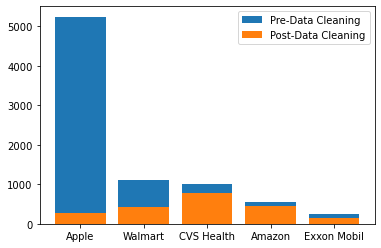

In [10]:
fig, ax = plt.subplots()

ax.bar(lengths.company,lengths.prior_length, label = 'Pre-Data Cleaning')
ax.bar(lengths.company,lengths.post_length, label = 'Post-Data Cleaning')
ax.legend();